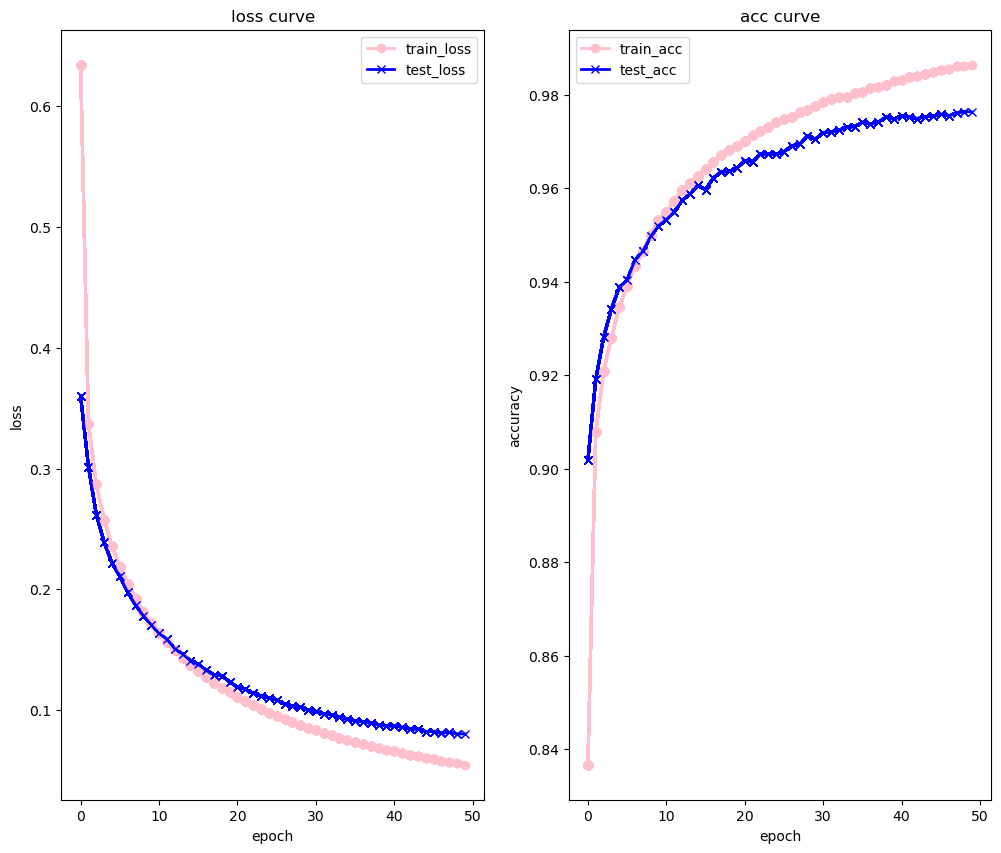

100%|██████████| 50/50 [1:01:34<00:00, 73.88s/it]


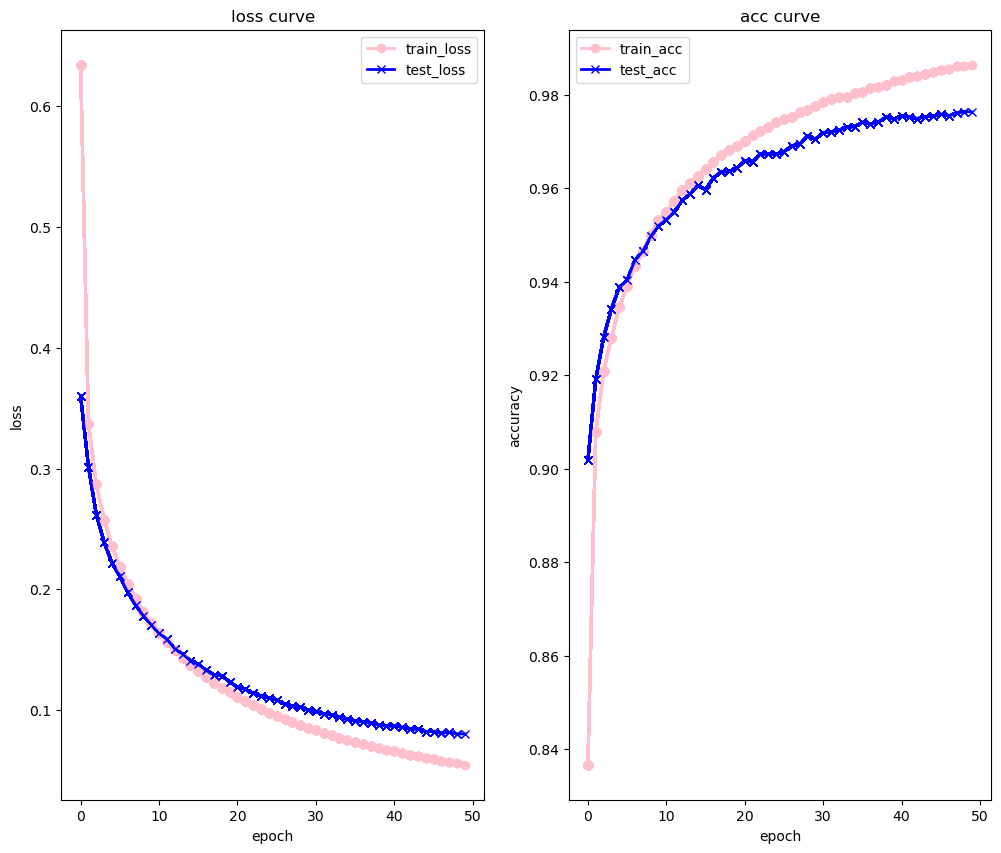

In [1]:
import matplotlib
%matplotlib inline
from model import MLP
from optimizer import SGD
import argparse
from tqdm import tqdm
from dataset import MNIST_Dataset
import cfg
import random
import numpy as np
from utils import AverageMeter,compute_acc,Accuracy_averagemeter
from tensor import Tensor
import logging
import os
import matplotlib.pyplot as plt

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

SEED = 729608
random.seed(SEED)
np.random.seed(SEED)
LOG_FMT = "%(asctime)s - %(filename)s[line:%(lineno)d] - %(levelname)s: %(message)s"

def augment_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs',type=int,default=cfg.epoch)
    parser.add_argument('--lr',type=float,default=cfg.lr)
    parser.add_argument('--batch-size',type=int,default=cfg.batch_size)
    parser.add_argument('--log-dir',type=str,default='./log/log2/')

    return parser

def split_batch(index_list,batch_size):
    batch_index = random.sample(index_list, batch_size)
    for each in batch_index:
        index_list.remove(each)

    return np.array(batch_index)

def main():
    parser = augment_parser()
    args = parser.parse_args(args=[])
    dataset = MNIST_Dataset()
    train_data,test_data,train_label,test_label = dataset.train_data,dataset.test_data,dataset.train_label,dataset.test_label
    mlp = MLP()
    optimizer = SGD(mlp.layers[:-1], args.lr)

    log_dir = args.log_dir
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
        # os.system(f'touch {log_dir + "train.log"}')
        # os.system(f'touch {log_dir + "test.log"}')

    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []

    plt.figure(figsize=(12,10))

    for i in tqdm(range(args.epochs)):
        train_loss, train_acc = train_epoch(train_data,train_label,mlp,optimizer,batch_size=args.batch_size,
                                            lr=args.lr,cur_epoch=i,log_file=log_dir + 'train.log')
        test_loss, test_acc = test_epoch(test_data,test_label,mlp,i,log_file=log_dir + 'train.log')
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

        plt.subplot(1,2,1)
        plt.plot(train_loss_list,color='pink',marker='o',linewidth=2,label='train_loss')
        plt.plot(test_loss_list,color='blue',marker='x',linewidth=2,label='test_loss')
        if i==0:
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.title('loss curve')
            plt.legend(loc='best')
            
        plt.subplot(1,2,2)
        plt.plot(train_acc_list, color='pink', marker='o', linewidth=2, label='train_acc')
        plt.plot(test_acc_list, color='blue', marker='x', linewidth=2, label='test_acc')
        if i == 0:
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.title('acc curve')
            plt.legend(loc='best')
        
        if is_ipython:
            display.clear_output(wait=True)
            display.display(plt.gcf())

def train_epoch(train_data,train_label,mlp,optimizer,batch_size,lr,cur_epoch,log_file):
    mlp.train()
    logging.basicConfig(
        level=logging.INFO,
        filename=log_file,
        filemode="w",
        format=LOG_FMT
    )
    train_loss = AverageMeter()
    train_acc = Accuracy_averagemeter()
    index_list = [i for i in range(train_data.shape[0])]

    while len(index_list) >= batch_size:
        batch_index = split_batch(index_list, batch_size)
        batch_data, batch_label = train_data[batch_index, :], train_label[batch_index, :]
        batch_data = Tensor(value=batch_data)
        output, loss = mlp(batch_data, batch_label)
        train_loss.update(val=float(loss), n=batch_size)
        train_acc.update(val= compute_acc(output.value,batch_label), n=batch_size)
        mlp.backward(target=batch_label)
        optimizer.step()

    if len(index_list):
        bs = len(index_list)
        batch_index = index_list
        batch_data, batch_label = train_data[batch_index, :], train_label[batch_index, :]
        batch_data = Tensor(value=batch_data)

        output, loss = mlp(batch_data, batch_label)
        train_loss.update(val=float(loss), n=bs)
        train_acc.update(val=compute_acc(output.value, batch_label), n=bs)
        mlp.backward(target=batch_label)
        optimizer.step()

    log_info = 'Train Epoch {0} --- train loss : {1} --- train accuracy:{2}'.format(cur_epoch + 1, train_loss.avg,train_acc.avg)
    logging.info(log_info)
    return train_loss.avg, train_acc.avg

def test_epoch(test_data,test_label,mlp,cur_epoch,log_file):
    mlp.eval()
    test_loss = AverageMeter()
    test_acc = Accuracy_averagemeter()
    logging.basicConfig(
        level=logging.INFO,
        filename=log_file,
        filemode="w",
        format=LOG_FMT
    )

    for i in range(test_data.shape[0]):
        data, label = test_data[i].reshape(1,-1),test_label[i].reshape(1,-1)
        data = Tensor(value=data)
        pred, loss = mlp(data,label)
        test_loss.update(val=float(loss))
        test_acc.update(val=int(compute_acc(pred.value,label)))

    log_info = 'Test Epoch {0} --- test loss : {1} --- test accuracy:{2}'.format(cur_epoch + 1, test_loss.avg,test_acc.avg)
    logging.info(log_info)
    return test_loss.avg, test_acc.avg


if __name__ == "__main__":
    main()